# 4 Introduction to computational radiometry with pyradi

This notebook forms part of a series on computational optical radiometry.  The notebooks can be downloaded from \cite{Willers2014github}. These notebooks are constantly revised and updated, please revisit from time to time.  

This notebook was last tested with Python 3.8.3. Consider moving to Python 3.8 if you are not already using it.

NOTE: The functions used in this notebook are mostly part of pyradi, available here \cite{pyradiPythontoolkit2012}.


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

This notebook provides a description of the basics of radiometric spectral variables and conversions between spectral densities, generic filter functions, generic detector functions, and reading and plotting spectral data. 
It then moves on to how to calculate spectral integrals, calculate spectral effective values, spectral convolution, colour coordinate calculations, and spatial integrals.

In [3]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

## Spectral variables

Consider the mathematical sine function $s(t) = A \sin(2\pi f t)$. Here $f$ is the frequency, $t$ is time and $A$ is the amplitude. As a mathematical function all three these parameters determine the value of the function. A sine wave generator on an engineer's workbench creates a temporal sine wave, i.e., a wave shape of sinusoidal characteristics, that varies with time.  The engineer can adjust the properties of the signal by changing the frequency $f$ or amplitude $A$ by turning a knob on the instrument.  The engineer cannot adjust the time $t$, because time is not a free variable in the sine wave generator, time flows as part of the human reality.  We can say that the sine wave _depends_ only on $f$ and $A$, but it _varies_ with time $t$.

Imagine a pipe with water flowing through it. One can measure the volume of water flowing past a fixed point in a given time period; the longer the time period, the larger the water volume.  It makes sense to define a temporal _flow rate_  expressed e.g., in cubic metres per second (at given time $t$).  Now generalise this notion to some form of _density_  with units of [something/s], [something/m$^3$], or [something/$\mu$m].
These variables can be integrated over time/volume/spectral density to arrive at a cumulative quantity.  The key observation here is that a quantity can be expressed as a density over time or volume, or in the radiometry case a quantity over a spectral band.

The spectral domain is similar to the time domain: it is not a free variable that can be adjusted, but rather provides a domain of observation against which an object's properties can be calculated or measured. These properties are said to _vary_ with the spectral variable. Some spectral properties _depend_ on free variables, e.g., Planck radiance _depends_ on the temperature of the object, but _varies_ with spectral variable.

Spectral domains (Sec 2.3.3)  are commonly expressed in wavelength $\lambda$, wavenumber $\tilde{\nu}$ (the number of waves that will fit into a 1-cm length, written as one word) or frequency $f$. In the optical domain wavelength and wavenumber are more commonly used than frequency.  Wavelength is commonly given in units of nanometres (nm) or micrometres ($\mu$m), wavenumber in (cm$^{-1}$) and frequency in [Hz].

Spectral variables come in two varieties: variable without density (equivalent to the sine wave) and density variables (equivalent to the water in the pipe).  Variables without density include spectral transmittance of a filter, the atmosphere or emissivity.  Variables with density include Planck radiation.  Spectral density values have units of 
[something/$\mu$m], 
[something/cm$^{-1}$] or 
[something/Hz].

The total quantity of a spectral variable over a spectral range is determined by integrating the spectral variable over the spectral range, similar to the water example above.

Wavelength and wavenumber are related by $\lambda = 10^4/\tilde{\nu}$ (Sec 2.3.3).  The conversion of spectral densities requires the derivative of the previous relation $d \tilde{\nu} = -d\lambda \,10^4/\lambda^2=-d\lambda\, \tilde{\nu}^2 /10^4$.


The sample grid spacing in wavelength and/or wavenumber is not critical, just so long that all the spectral data are on the same grid values. This common spacing is important when we multiply different spectral curves, e.g., sensor response, atmospheric transmittance and source radiance together as in 
$S\;\tau_\textrm{atm}\;L_\textrm{source}$, as is shown in the following picture.

![](pic/spectralmult.png)

The $\lambda$ sampling for all the elements must be on the same grid to obtain a meaningful result. 
If the various data curves are not sampled at the same spacing and we multiply the incorrectly shifted or scaled spectral scales, the result has no meaning.
Doing spectral calculations with incorrect spectral grid spacing is like adding a number in base-2 to a number in base-10; it has no arithmetic meaning.

Hence it is important for this and all other  problems that we spectrally sample the source, the atmosphere and the sensor with exactly the same spectral grid. If the raw data from the files do not share a common spectral grid, we must interpolate all of them to the required common grid.

Note that the Modtran data is provided on regular spacing in wavenumbers; but this means varying spacing in wavelength domain (recall from the relationship between wavenumber and wavelength given above) and from my book:

![](pic/wnwlrelation.png)



## Spectral variables in pyradi

Spectral variables are represented in Python as Numpy arrays (Sec D.3). These arrays are rank-one (N,) or rank-two (N,1), but always represent the spectral variable as a vector of values.  The conversion between rank one and rank two is done by reshaping the vector.

In [4]:
%matplotlib inline
import numpy as np

#create a micrometre wavelength spectral range with 101 samples
#from 400 nm to 800 nm
wl1 = np.linspace(0.4, 0.8, 101) #rank (N,)
wl2 = wl1.reshape(-1,1) #convert to rank (N,1)
wl3 = wl2.reshape(1,-1) #convert to rank (1,N)
wl4 = wl2.reshape(-1,)  #convert back to rank (N,)
print('Wavelength vector as rank one, has shape {}'.format(wl1.shape))
print('Wavelength vector as rank two, has shape {}'.format(wl2.shape))
print('Wavelength vector as rank two, has shape {}'.format(wl3.shape))
print('Wavelength vector as rank one, has shape {}'.format(wl4.shape))

Wavelength vector as rank one, has shape (101,)
Wavelength vector as rank two, has shape (101, 1)
Wavelength vector as rank two, has shape (1, 101)
Wavelength vector as rank one, has shape (101,)


It appears that in Numpy a rank-one array (N,) behaves like a row vector (1,N) in some instances. In pyradi it is more convenient and natural to consider spectral variables as column vectors (N,1), therefore this rehaping from (N,) to (N,1) takes place quite frequently.  Why consider spectral variables as (N,1) arrays? When saving spectral data to file, it seems more natural (and easier to view/edit) if the spectral range varies along the rows in the file: each spectral value is on a new line in the file. This approach also lends itself to saving more than one spectral variable in a file where the first column represents the spectral domain and all remaining columns represent spectral variables. A case in point is the Modtran tape7 file. So as a general rule: pyradi always expect spectral variables of one of the these shapes:

In [5]:
wl1 = np.linspace(0.4, 0.8, 101) #rank (N,)
wl2 = wl1.reshape(-1,1) #convert to rank (N,1)

The pyradi library provides several conversion functions to convert between different spectral domains and also to convert between spectral densities. The units must  consistently be in micrometres ($\mu$m), wavenumber in (cm$^{-1}$) or frequency in [Hz] - any other units will provide incorrect results.


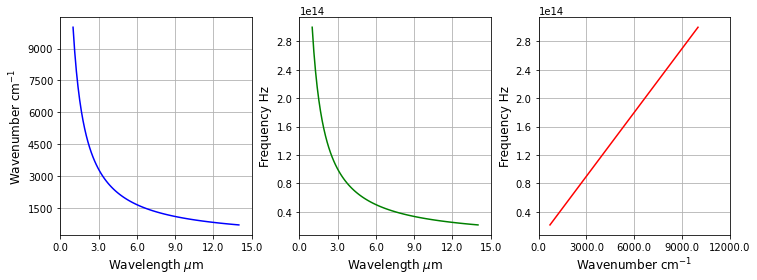

In [6]:
import pyradi.ryutils as ryutils
import pyradi.ryplot as ryplot

wl = np.linspace(1, 14, 101).reshape(-1,1) # wavelength 
wn = ryutils.convertSpectralDomain(wl, type='ln') # wavenumber
f = ryutils.convertSpectralDomain(wn, type='nf') # frequency

p = ryplot.Plotter(1,1,3,figsize=(12,4));
p.plot(1,wl,wn,'','Wavelength $\mu$m', 'Wavenumber cm$^{-1}$',maxNX=5);
p.plot(2,wl,f,'','Wavelength $\mu$m', 'Frequency Hz',maxNX=5);
p.plot(3,wn,f,'','Wavenumber cm$^{-1}$', 'Frequency Hz',maxNX=4);


Converting spectral density values are similar to converting between spectral domains. In this example the `pyradi.ryplanck.planck` function
is used to calculate the spectral density of Planck radiance (Sec 3.1, Sec D.4.1) for a temperature of 1000 K as a wavelength spectral density. This value is then converted to a wavenumber spectral density. Finally, the Planck radiance is calculated in the wavenumber domain, which should give the same result as the converted spectral radiance.

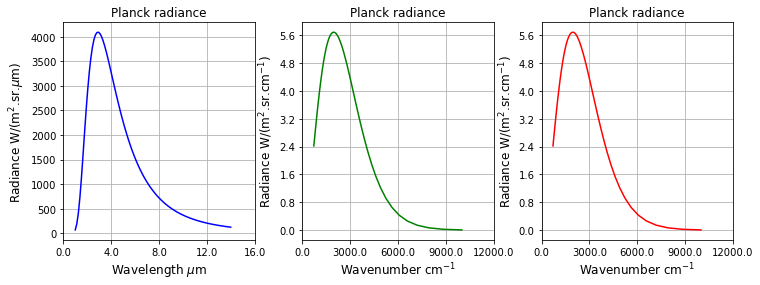

In [7]:
import pyradi.ryplanck as ryplanck

wl = np.linspace(1, 14, 101)#.reshape(-1,1) # wavelength 
wn = ryutils.convertSpectralDomain(wl, type='ln') # wavenumber

radiancewl = ryplanck.planck(wl,1000.0, 'el') / np.pi # W/(m2.sr.um)
_,radiancewn1 = ryutils.convertSpectralDensity(wl,radiancewl, 'ln')
radiancewn2 = ryplanck.planck(wn,1000, 'en') / np.pi

p = ryplot.Plotter(2,1,3,figsize=(12,4))
p.plot(1,wl, radiancewl,'Planck radiance','Wavelength $\mu$m', 
       'Radiance W/(m$^2$.sr.$\mu$m)',maxNX=4)
p.plot(2,wn, radiancewn1,'Planck radiance','Wavenumber cm$^{-1}$', 
       'Radiance W/(m$^2$.sr.cm$^{-1}$)',maxNX=4)
p.plot(3,wn, radiancewn2,'Planck radiance','Wavenumber cm$^{-1}$', 
       'Radiance W/(m$^2$.sr.cm$^{-1}$)',maxNX=4);

See the section 'Performing-spectral-integrals' below.

## Interpolation of Spectral Variables

SciPy has a number of interpolation options in `scipy.interpolate`.  

The one-dimensional interpolation scheme enables the definition of the lookup table as a function by using `scipy.interpolate.interp1d`.  The user can define the interpolation scheme to be used - the default is `kind='linear'`, to do cubic interpolation use `kind='cubic'`.  In the example below observe the difference between the two schemes. 

The example below is an ill-posed problem: normally one would have a much denser input data set.  The purpose with using this poor data set is to illustrate the dangers of interpolation. Do not use a potentially unstable interpolation scheme such as cubic interpolation on a poor data set such as the one shown below.

The input data set has only four samples.  The ordinate (y) data has a slight oscillation.  The abscissa (x) data are defined in the wavelength space. Equivalently, the abscissa (x) data are also defined in the wavenumber space, because $\tilde{\nu}=10^4/\lambda$. This is the only information available, there is no requirement on the values between the stated abscissa.

Important: *by selecting the interpolation scheme (linear, cubic, etc.), you are implicitly making a modelling assumption*.  Linear interpolation in the wavelength space means a non-linear interpolation in wavenumber space and vice versa (because wavelength and wavenumber are nonlinearly related). Stated differently: if your input data set was compiled to be interpolated linearly in wavelength space (blue lines), then linear interpolation in wavenumber space will give the wrong results (red lines).

Also, by *selecting between the linear and cubic (or any other scheme) you are also making a modelling assumption*.  Compare the difference between the results for the linear interpolation (red/blue) and the cubic interpolation (green/cyan) lines.

It is evident in the cubic interpolation graphs (green/cyan) that cubic/high-order interpolation schemes do not take kindly to large variations in abscissa increments. For example, the large increment from 10 to 20 in the wavelength space (green line) resulted in a huge variation in the spline curve.  Likewise, the large wavenumber increment from 5000 to 10000  (or 1 to 2 $\mu$m) (cyan line) causes a large variation.

From this experiment we can draw the following conclusions:

1. Clearly state the space (wavelength/wavenumber) where the input data set applies.  Do interpolation *only* in the prescribed space.

2. Ensure that the input data set samples at similar/even density throughput the abscissa domain.  If no input data is available in some subranges in the abscissa domain, construct synthetic data by some modelling assumptions, to ensure even density.  Such an even spread in abscissa values will limit wide swings in the high-order interpolation schemes.

Thanks to Riana Willers for pointing out the subtle matter of interpolation in wavelength or wavenumber space.

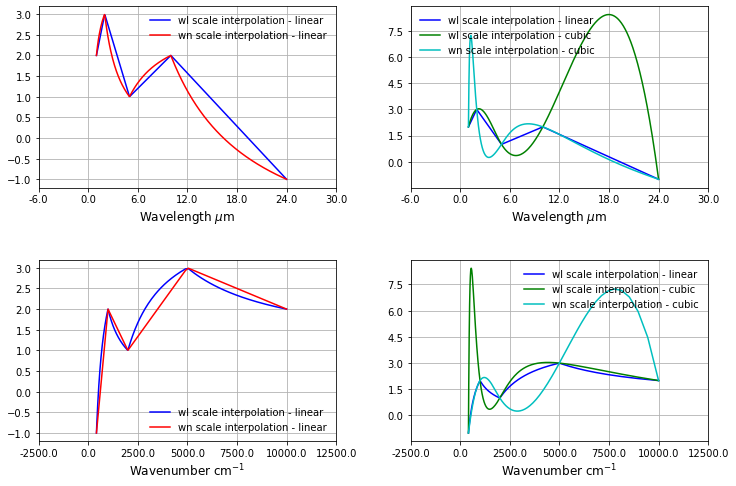

In [10]:
from scipy import interpolate
import pyradi.ryplot as ryplot
import numpy as np
%matplotlib inline

# create input data in wavelength and wavenumber domain
maxx = 24
wl = np.asarray([1, 2, 5, 10, maxx])
wn = 1e4 / wl # wl and wn values precisely align
fn = np.asarray([2,3,1, 2, -1])

# create the plotting samples - much tighter than input data
wli = np.linspace(1,maxx,400)
wni = 1e4 / wli

#create the lookup functions
fwll = interpolate.interp1d(wl,fn)
fwlc = interpolate.interp1d(wl,fn, kind='cubic')
fwnl = interpolate.interp1d(wn,fn)
fwnc = interpolate.interp1d(wn,fn, kind='cubic')

p = ryplot.Plotter(1,2,2,figsize=(12,8))
p.plot(1,wli,fwll(wli),label=['wl scale interpolation - linear'],plotCol=['b'])
p.plot(1,wli,fwnl(wni),'','Wavelength $\mu$m',label=['wn scale interpolation - linear'],plotCol=['r'], maxNX=5)
p.resetPlotCol()
p.plot(2,wli,fwll(wli),label=['wl scale interpolation - linear'],plotCol=['b'])
p.plot(2,wli,fwlc(wli),label=['wl scale interpolation - cubic'],plotCol=['g'])
p.plot(2,wli,fwnc(wni),'','Wavelength $\mu$m',label=['wn scale interpolation - cubic'],plotCol=['c'], maxNX=5)
p.resetPlotCol()
p.plot(3,wni,fwll(wli),label=['wl scale interpolation - linear'],plotCol=['b'])
p.plot(3,wni,fwnl(wni),'','Wavenumber cm$^{-1}$',label=['wn scale interpolation - linear'],plotCol=['r'], maxNX=5)
p.resetPlotCol()
p.plot(4,wni,fwll(wli),label=['wl scale interpolation - linear'],plotCol=['b'])
p.plot(4,wni,fwlc(wli),label=['wl scale interpolation - cubic'],plotCol=['g'])
p.plot(4,wni,fwnc(wni),'','Wavenumber cm$^{-1}$',label=['wn scale interpolation - cubic'],plotCol=['c'], maxNX=5);


## Generic spectral filter response

In most real-world system analyses, filter spectral responses will be measured and used in tabular formats.  However, in some instances it is convenient to create spectral filter shapes according to a parameter set. The pyradi library has a function `pyradi.ryutils.sfilter` to assist in calculating a variety of spectral filter shapes.  This function has the form (Sec D.4.2):

$$\tau_\lambda =\tau_s + \tau_p
\exp\left[ -\left(\frac{2(\lambda-\lambda_c)}{\Delta\lambda}\right)^s\right].
$$

This function takes a spectral variable $\lambda$, the centre wavelength $\lambda_c$, the spectral width $\Delta\lambda$, the sharpness of cutoff $s$  (if $s=2$, the
curve has a Gaussian shape, and if $s=\infty$, the curve has a square top-hat shape), transmittance in the pass band $\tau_p$ and stop band $\tau_s$ and the type of filter. The use of the function is best demonstrated by graphical means.

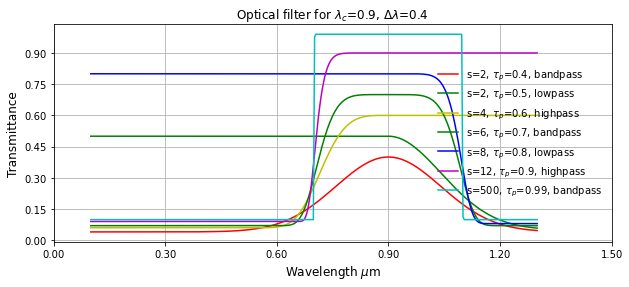

In [11]:
wavelength = np.linspace(0.1, 1.3, 350).reshape(-1, 1)

#demonstrate the different filter types
width = 0.4
center = 0.9
filterExp=[2, 2,  4, 6,  8, 12, 500] # shaprness
filterPass=[0.4, 0.5,  0.6, 0.7,  0.8, 0.9, 0.99] # tau pass
filterSupp = np.asarray(filterPass) * 0.1 # tau stop
filterType=['bandpass', 'lowpass', 'highpass', 'bandpass', 'lowpass', 
            'highpass', 'bandpass']
filterTxt = [r's={0}, $\tau_p$={2}, {1}'.format(s,y,z) for s,y,
             z in zip(filterExp, filterType, filterPass) ]
filters = ryutils.sfilter(wavelength,center, width, filterExp[0], 
                          filterPass[0],  filterSupp[0], filterType[0])

for i,exponent in enumerate(filterExp[1:]):
    tau=ryutils.sfilter(wavelength,center, width, filterExp[i+1],filterPass[i+1],  
                        filterSupp[i+1], filterType[i+1])
    filters =  np.hstack((filters,tau))

#plot sample filters 
smpleplt = ryplot.Plotter(1, 1, 1, figsize=(10, 4));
smpleplt.plot(1, wavelength, filters,
    r"Optical filter for $\lambda_c$={0}, $\Delta\lambda$={1}".format(center,width),
    r'Wavelength $\mu$m', r'Transmittance', \
            ['r', 'g', 'y','g', 'b', 'm','c'],label=filterTxt,maxNX=5,xAxisFmt="%.2f");

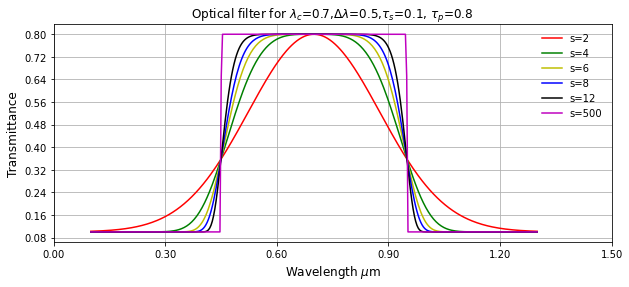

In [12]:
#all passband, different shapes
width = 0.5
center = 0.7
filterExp=[2,  4, 6,  8, 12, 500] # sharpness

filterTxt = ['s={0}'.format(s) for s in filterExp ]
filters = ryutils.sfilter(wavelength,center, width, filterExp[0], 0.8,  0.1)
for exponent in filterExp[1:]:
    filters =  np.hstack((filters, ryutils.sfilter(wavelength,center, width, 
                                              exponent, 0.8,  0.1)))
smpleplt = ryplot.Plotter(1, 1, 1, figsize=(10, 4));
smpleplt.plot(1, wavelength, filters,
    r"Optical filter for $\lambda_c$=0.7,$\Delta\lambda$=0.5,$\tau_{s}$=0.1, $\tau_{p}$=0.8",
    r'Wavelength $\mu$m', r'Transmittance', \
            ['r', 'g', 'y','b', 'k', 'm'],label=filterTxt,maxNX=5,xAxisFmt="%.2f");

## Detector spectral response

Detector spectral responsivity values are also normally measured or taken from detector data sheets. In the absence of such information the shape can be calculated from a detailed bulk detector model, such as provided in `pyradi.rydetector`, but sometimes a simplified shape is required.  Such a simple photon detector responsivity can be calculated with the `pyradi.ryutils.responsivity` function. The function takes the form (Sec D.4.3):

$${\cal R}_\lambda= k\left[
\left(\frac{\lambda}{\lambda_c} \right)^a -
\left(\frac{\lambda}{\lambda_c} \right)^n
\right]\;\;\;{\rm for}\;\;\; {\cal R}_\lambda>0, \;\;\; 0 \;\;\;{\rm otherwise}.$$

This function takes a wavelength spectral variable $\lambda$, the peak wavelength value $\lambda_c$, the sharpness of cuton (lower wavelength range)  $a$, the sharpness of cutoff (longer wavelength range) $n$, and an amplitude scaling factor $k$. Best results are obtained for $0\leq a \leq 5$ and $5\leq n \leq 50$. 
The use of the function is best demonstrated by graphical means.

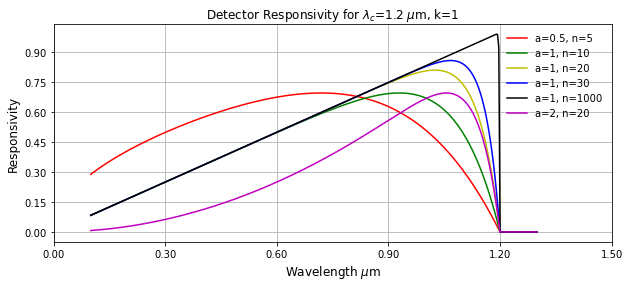

In [13]:
lwavepeak = 1.2
params = [(0.5, 5), (1, 10), (1, 20), (1, 30), (1, 1000), (2, 20)] #cut-on and cut-off
parameterTxt = ['a={0}, n={1}'.format(s[0], s[1]) for s in params ]
responsivities = ryutils.responsivity(wavelength,lwavepeak, params[0][0], params[0][1], 1.0)
for param in params[1:]:
    responsivities =  np.hstack((responsivities, ryutils.responsivity(wavelength,lwavepeak, param[0], param[1], 1.0)))

smpleplt = ryplot.Plotter(1, 1, 1, figsize=(10, 4))
smpleplt.plot(1, wavelength, responsivities, "Detector Responsivity for $\lambda_c$=1.2 $\mu$m, k=1", r'Wavelength $\mu$m',\
           r'Responsivity', \
           ['r', 'g', 'y','b', 'k', 'm'],label=parameterTxt,maxNX=5,xAxisFmt="%.2f");

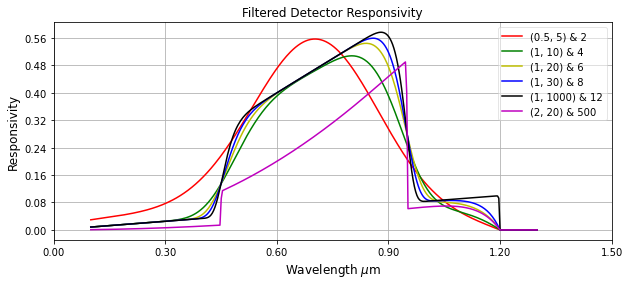

In [15]:
# here we simply multiply the responsivity and spectral filter spectral curves.
# this is a silly example, but demonstrates the spectral integral.
filtreps = responsivities * filters
parameterTxt = [str(s)+' & '+str(f) for (s, f) in zip(params, filterExp) ]

smpleplt = ryplot.Plotter(1, 1, 1, figsize=(10, 4))
smpleplt.plot(1, wavelength, filtreps, "Filtered Detector Responsivity",
              r'Wavelength $\mu$m',\
           r'Responsivity', \
           ['r', 'g', 'y','b', 'k', 'm'],label=parameterTxt,legendAlpha=0.5,maxNX=5,xAxisFmt="%.2f");

## Plotting of spectral variables

The title appears trivial, but there is a hidden subtlety when working with and plotting radiometric variables. In the section above  ``spectral variables in pyradi'', the data was created in the wavelength domain (using the `linspace` function), but plotted in both wavelength and wavenumber domains. Note that the data was not resampled to wavenumber domain before plotting: the wavenumber plots are not at constant intervals.  The wavelength domain was merely recalculated to wavenumber domain. This is illustrated in the graph below.

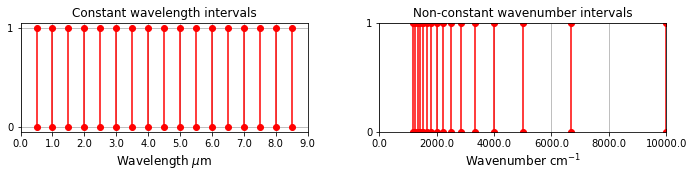

In [16]:
wlc = np.linspace(0.5, 8.5, 17).reshape(-1,1) # wavelength 
wnc = ryutils.convertSpectralDomain(wlc, type='ln') # wavenumber
p = ryplot.Plotter(2,1,3,figsize=(18,2))
for i in range(wlc.shape[0]):
    p.plot(1,np.array([wlc[i],wlc[i]]), np.array([0,1.]), 'Constant wavelength intervals',
           'Wavelength $\mu$m', plotCol=['r'], markers=['o'], maxNY=1)
    p.plot(2,np.array([wnc[i],wnc[i]]), np.array([0,1.]), 'Non-constant wavenumber intervals',
           'Wavenumber cm$^{-1}$',plotCol=['r'], markers=['o'], maxNX=5, maxNY=1, pltaxis=[0, 10000, 0, 1]);

The data and the plot are equally 'valid' or true in either domain, because the domain merely samples the data at different spectral intercepts.  So we can load and process data in either domain and plot in either domain, without losing any truth value. Plot in whatever domain illustrates your argument the best.

You should however take care when dealing with spectral densities: it is possible and mathematically allowable to plot a wavenumber density with units of W/(m$^2$.sr.cm$^{-1}$) against a wavelength domain with units of $\mu$m, but it does not make much practical sense to do so.

Consider the intervals in both cases, here calculated with `numpy.diff`. Note that the intervals are constant and positive for the wavelength scale, but negative and non-constant for the wavenumber scale as converted from the wavelength scale.  Recall from Section `Spectral-variables' above, that  $d \tilde{\nu} = -d\lambda \,10^4/\lambda^2=-d\lambda\, \tilde{\nu}^2 /10^4$. In other words the spectral intervals change in the opposite sense: the wavelength domain scale increases (positive intervals), but when converted to wavenumber domain the scale decreases (negative intervals).

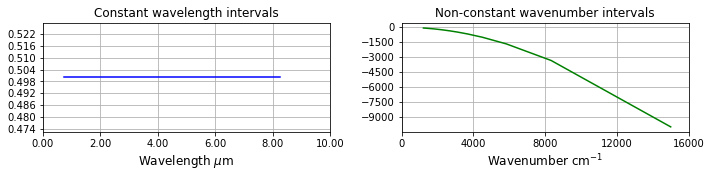

In [18]:
p = ryplot.Plotter(3,1,3,figsize=(18,2))
p.plot(1,(wlc[1:]+wlc[:-1])/2, np.diff(wlc,axis=0), 'Constant wavelength intervals',
       'Wavelength $\mu$m',maxNX=5,xAxisFmt="%.2f");
p.plot(2,(wnc[1:]+wnc[:-1])/2, np.diff(wnc,axis=0), 'Non-constant wavenumber intervals',
       'Wavenumber cm$^{-1}$',maxNX=5,xAxisFmt="%.0f");

## Mixing spectral data from different sources

When working with mixed domains, e.g., Modtran transmittance data in wavenumber domain and sensor spectral response in wavelength domain, you have to resample from the one to the other, to at least get samples at the same spectral intercepts. So, work in either domain, but be sure that the sampled data all relate to the same fundamental spectral baseline. The pyradi library provides functions to resample data when reading in the data from file, with minimal coding overhead (see  `ryfiles.loadColumnTextFile`).

## Performing spectral integrals

A repeating pattern in computational radiometry is the spectral integral: integrating the sum of a spectral variable between an upper and a lower limit. For example, this calculation is required to determine the total inband radiance over a wide spectral range.  We use the mathematical integral notation to indicate such integrals, but in practice, these are calculated using numerical summation.
$$
L = \int_{\lambda_0}^{\lambda_1} L_\lambda d\lambda = \sum_{i=0}^{N}L(i)\Delta\lambda(i)
$$
where the sample $i=0$ corresponds with the sample at $\lambda_0$ and the sample $i=N$ corresponds with the sample at $\lambda_N$.
The sum above is a general statement and does not make any assumption about the spectral domain sampling interval. 
If the spectral domain sampling interval has fixed increments $\Delta\lambda(i)=\Delta\lambda$ then
$$
L = \int_{\lambda_0}^{\lambda_1} L_\lambda d\lambda = \Delta\lambda\sum_{i=0}^{N}L(i).
$$



The spectral interval (constant interval on wavelength or wavenumber) is not of major significance when performing  spectral multiplications or when plotting the data. It is however necessary to allow for the (potentially varying) spectral intervals when doing spectral integrals.

![](pic/TrapezoidRule1.png)

The picture above shows non-constant intervals on the $x$ axis. When using the trapezoidal rule the integral is calculated as the summation of areas where the area is given by the $\Delta x$sampling along the $x$ axis and the mean height along the $y$ axis
\begin{equation}
\int_a^b f(x) dx \approx \sum_{n=0}^{N-1}\frac{1}{2}(f_n+f_{n+1})(x_n-x_{n+1}).
\end{equation}
If the intervals along the $x$ axis is constant, the integral reduces to
\begin{equation}
\int_a^b f(x) dx \approx \Delta x\sum_{n=0}^{N-1}\frac{1}{2}(f_n+f_{n+1}).
\end{equation}
Both Matlab and Python have a trapezium integration function `trapz` where the user supply values for the $x$ sampling points and the $y$ function values as two matched vectors.  The function then performs the integral as defined in the first equation above, accounting for nonconstant intervals in $x$.

So in summary, spectral multiplication and integration 

1. requires all spectral variables to be on the same spectral sampling grid and 
1. allows numeric integration by the trapezium rule provided the spectral sampling vector is given as the $x$ vector.


In pyradi the spectral integrals are typically (and naively) calculated using the `numpy.trapz` trapezoidal integration function. This function has the signature  
    `numpy.trapz(y, x=None, dx=1.0, axis=-1)`   
where `y` is the value to be integrated,  `x` is the sampling points $(x_0, x_1, x_2,\cdots,x_N)$ corresponding to each of the samples in $y$, `dx`  a scalar for the *constant* $\Delta x$,  and `axis` is the axis along which integration is done.
If the spectral domain $x$ is sampled at regular intervals the `x` array is not required and unless `dx` is specified, it  is assumed that `dx`=1. 

If the spectral variable is not on constant intervals, such as wavenumber values converted to wavelength values by $\lambda = \num{1e4}/\tilde{\nu}$,
the $x$ vector must be supplied.


In [20]:
wl = np.linspace(1, 14, 1001)#.reshape(-1,1) # wavelength 
temperature = 1000.0 # K
radiancewl = ryplanck.planck(wl,temperature, 'el') / np.pi
print('Integral(1) = {} W/(m^2.sr)'.format( (wl[1]-wl[0]) * np.trapz(radiancewl)) )
print('Integral(2) = {} W/(m^2.sr)'.format( np.trapz(radiancewl, dx=(wl[1]-wl[0]))) )
print('Integral(3) = {} W/(m^2.sr)'.format( np.trapz(radiancewl,wl)) )

Integral(1) = 17373.054062811796 W/(m^2.sr)
Integral(2) = 17373.054062811796 W/(m^2.sr)
Integral(3) = 17373.054062811927 W/(m^2.sr)


If the spectral interval is not constant, i.e, wavelength domain converted to wavenumber domain, the  `dx` or pre-multiplication approach is no longer valid. The only possibility to calculate the integral is to give the value of `x`, with its non-constant intervals. Continuing from the previous example, convert the wavelength domain to the wavenumber domain, calculate the spectral density in wavenumber units W/(m$^2$.sr.cm$^{-1}$) and calculate the integral using the (non-constant-interval) wavenumber domain as `x`:

In [21]:
wn = ryutils.convertSpectralDomain(wl, type='ln') # wavenumber
radiancewn = ryplanck.planck(wn, temperature, 'en') / np.pi
print('Integral(wn) = {} W/(m^2.sr)'.format( np.trapz(radiancewn, wn )))

Integral(wn) = -17373.324662079165 W/(m^2.sr)


What happened here? The integral appears to have (practically) the same absolute values, but the sign is wrong!

Recall from Section Spectral-variables above, that  $d \tilde{\nu} = -d\lambda \,10^4/\lambda^2=-d\lambda\, \tilde{\nu}^2 /10^4$.  We can see this by taking the first few elements of the `numpy.diff` along the spectral domains. Notice also that the wavelength interval is fixed, but the wavenumber interval varies.

In [22]:
print('First 5 intervals in wl: {}'.format(np.diff(wl)[:5]))
print('First 5 intervals in wn: {}'.format(np.diff(wn)[:5]))
#now calculate the intervals using the equations above:
print('First 5 intervals in wn: {}'.format( - np.diff(wl)[:5] * 1.0e4 / ((wl[:5] + wl[1:6])/2. )**2 ))
print('First 5 intervals in wn: {}'.format( - np.diff(wl)[:5] * ((wn[:5] + wn[1:6])/2. )**2 / 1.0e4))


First 5 intervals in wl: [0.013 0.013 0.013 0.013 0.013]
First 5 intervals in wn: [-128.33168806 -125.07961799 -121.94961792 -118.93565398 -116.03206055]
First 5 intervals in wn: [-128.32633585 -125.0745336  -121.94478481 -118.93105681 -116.0276851 ]
First 5 intervals in wn: [-128.33704049 -125.08470258 -121.95445123 -118.94025133 -116.03643617]


The intervals are correct in absolute magnitude (corresponding to the spectral samples), just opposite in sign. To fix this, just take the negative or the absolute value as in

In [23]:
print('Integral(wn) = {} W/(m^2.sr)'.format( - np.trapz(radiancewn, wn )))
print('Integral(wn) = {} W/(m^2.sr)'.format( np.abs( np.trapz(radiancewn, wn ))))

Integral(wn) = 17373.324662079165 W/(m^2.sr)
Integral(wn) = 17373.324662079165 W/(m^2.sr)


The other alternative is to flip the spectral domain around (to obtain positive increments) and then do the integral. But there is a catch here: the intervals are not constant, so you must flip (`numpy.flipud`) both the spectral density and spectral domain variables, to ensure matching elements.

In [24]:
#flip only wavenumber but not the wavenumber spectral density 
print('Integral(wn) = {} W/(m^2.sr) - wrong because of a mismatch between x and y ordering'.\
      format( np.trapz(radiancewn, np.flipud(wn) )))
#flip both wavenumber and wavenumber spectral density 
print('Integral(wn) = {} W/(m^2.sr)'.format( np.trapz(np.flipud(radiancewn), np.flipud(wn) )))

Integral(wn) = 27199.47222521353 W/(m^2.sr) - wrong because of a mismatch between x and y ordering
Integral(wn) = 17373.324662079165 W/(m^2.sr)


## Converting wideband values between radiant and photon rate units

The relationship between the photon rate radiometric units and radiant units are well defined for a single wavelength. It is best to calculate the spectral photon rate units from first principles and then integrate over the spectral band of interest. However on occasion the information may only be available in wideband radiant units, but the quantity must be expressed in photon rate units. For wideband data the question then arises which wavelength should be used in the conversion?  This section determines the appropriate wavelength to be used for the conversion for a given spectral band and source spectrum.

The appropriate conversion wavelength is determined at the wavelength where an accurate spectral calculation gives the same answer as an approximate wideband calculation.  The experimentation below indicates that the conversion wavelength is slightly longer than the center of the spectral band - photons at longer wavelengths have lower energy than at shorter wavelengths.

Responsivity is given by
\begin{equation}
R_e = \frac{\eta q \lambda}{hc},
\end{equation}
from which quantum efficiency can be determined as
\begin{equation}
\eta = \frac{R_e hc}{q \lambda}.
\end{equation}



wl min = 3.502627
wl mid = 4.1963013
wl max = 4.8899756


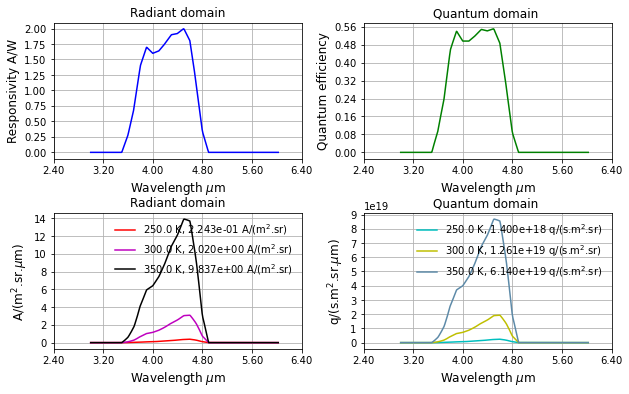

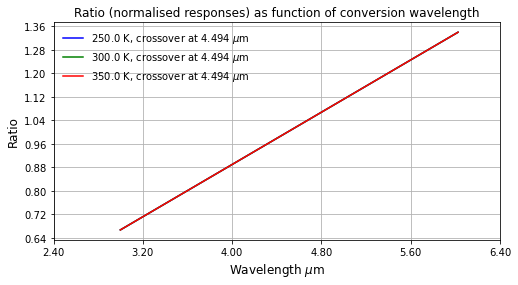

In [26]:
# to investigate the conversion for broadband data between photon rate units and radiant units
import scipy.constants as const

spec = np.loadtxt('data/InSb.txt')
wl = spec[:,0].reshape(-1)
respW = 2. * spec[:,2].reshape(-1)
respQ = respW * const.h * const.c / (wl * 1e-6 * const.e)

wlNan = np.where(respW==0,np.nan,wl)
wlcent = np.mean([np.nanmax(wlNan),  np.nanmin(wlNan)])
print('wl min = {}'.format(np.nanmin(wlNan)))
print('wl mid = {}'.format(wlcent))
print('wl max = {}'.format(np.nanmax(wlNan)))

p = ryplot.Plotter(1,2,2,figsize=(10,6));
p.plot(1, wl,respW, 'Radiant domain','Wavelength $\mu$m','Responsivity A/W',maxNX=5,xAxisFmt="%.2f");
p.plot(2, wl,respQ,'Quantum domain ','Wavelength $\mu$m','Quantum efficiency',maxNX=5,xAxisFmt="%.2f");

q = ryplot.Plotter(2,1,1,figsize=(8,4))
for temp in [250.,300.,350.]:
    Ve = respW * ryplanck.planck(wl,temp,'el') / np.pi
    Vq = respQ * ryplanck.planck(wl,temp,'ql') / np.pi
    Vei = np.trapz(Ve,-wl,axis=0)
    Vqi = np.trapz(Vq,-wl,axis=0)
    
    # convert from W to q/s
    qW = const.h * const.c /  (wl * 1e-6)
    ratio =  ((Vei/qW) / Vqi ) / (np.max(respW)/np.max(respQ))
    wlu = np.interp(1.,ratio[::-1],wl[::-1])
    q.plot(1, wl,ratio, 'Ratio (normalised responses) as function of conversion wavelength',
           'Wavelength $\mu$m', 'Ratio',
           label=['{} K, crossover at {:.3f} $\mu$m'.format(temp,wlu)],maxNX=5,xAxisFmt="%.2f");
    
    p.plot(3, wl,Ve, 'Radiant domain',
           'Wavelength $\mu$m', 'A/(m$^2$.sr.$\mu$m)',
           label=['{} K, {:.3e} A/(m$^2$.sr)'.format(temp,Vei)],maxNX=5,xAxisFmt="%.2f");
    p.plot(4, wl,Vq, 'Quantum domain ',
           'Wavelength $\mu$m', 'q/(s.m$^2$.sr.$\mu$m)',
           label=['{} K, {:.3e} q/(s.m$^2$.sr)'.format(temp,Vqi)],maxNX=5,xAxisFmt="%.2f");
#     p.plot(4, wl,Ve/const.e);


## Effective value normalisation

The effective value of a spectral variable is given by (Sec 7.2.2)

$$
{F}_{\rm eff} = \frac
{\int_{0}^{\infty}{F} {G}
d\lambda}
{\int_{0}^{\infty}{G} \lambda},
$$

where ${F}$ is the variable in question, and ${G}$ is a weighting function. Note that the effective value
of $F$ depends on the  shapes of both $F$ and $G$; the effective value of $F$ thus calculated therefore applies only to the specific weighting function $G$ - it is incorrect for any other shapes. 

To demonstrate the sensitivity of the effective value normalisation to the spectral variability of the input spectra, consider the effective detector responsivity calculated at different blackbody source temperatures from 500 K to 2000 K.  The InSb detector is modelled using the simple detector model in `ryutils.responsivity`.  The source radiance is the weighting function $G$, calculated by using `ryplanck.planck`.  The following graphs show the spectral detector responsivity ($F$ in the above equation) and the effective responsivity as calculated for the range of temperatures.  The calculation requires the calculation of a separate quotient and integral for each temperature, yet there are no loops!  This magic is achieved by constructing two-dimensional arrays with wavelengths along the row (0'th) axis and temperature along the column (1'st) axis.  The first of these arrays is returned by the `ryplanck.planck` function (because a vector of wavelengths and a vector of temperatures are passed to the function). The second array is obtained by using the `numpy.meshgrid` array (google to see how this function works).  The two arrays are used to calculate the numerator of the quotient.  The integrals are implemented using the `numpy.trapz` function, integrating along the wavelength axis=0 direction. This integration returns a vector of values corresponding to the temperature values along the columns axis=1.

Note the very wide variation in effective responsivity when calculated with different source temperatures. This stems from the fact that the responsivity is weighted differently by the different Planck radiance curves resulting from the different source temperatures.  The highest effective responsivity occurs near the wavelength where the peak of the Planck radiance matches the peak of the detector responsivity.

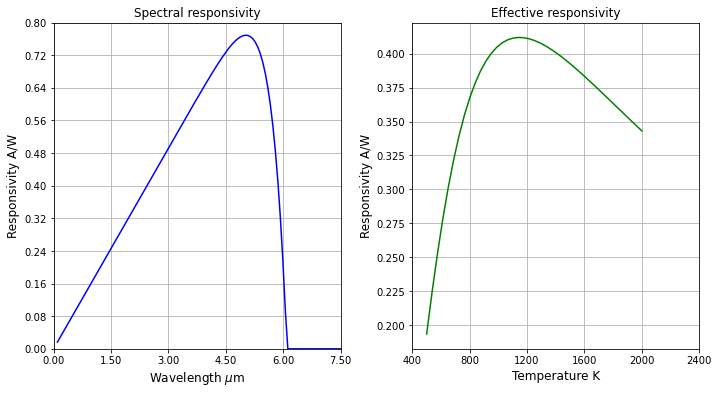

In [27]:
wavelength = np.linspace(0.1, 20, 305).reshape(-1, 1)
detector = ryutils.responsivity(wavelength, 6.1, 1, 15, 1.0)
temperatures = np.linspace(500, 2000, 41)
spectralBaseline = ryplanck.planck(wavelength,temperatures,'el')
_, detVar = np.meshgrid(temperatures, detector)
spectralWeighted = spectralBaseline * detVar
effResp = np.trapz(spectralWeighted, wavelength, axis=0 ) / np.trapz(spectralBaseline, wavelength, axis=0)

p = ryplot.Plotter(2,1,3,figsize=(18,6))
p.plot(1,wavelength,detector,'Spectral responsivity','Wavelength $\mu$m', 'Responsivity A/W',pltaxis=[0.5,7,0,0.8],maxNX=5,xAxisFmt="%.2f");
p.plot(2,temperatures,effResp,'Effective responsivity','Temperature K', 'Responsivity A/W',maxNX=5,xAxisFmt="%.0f");

## File loading and saving

Data are easily read in from files.  The format most easy to read/write is ASCII coding in a tabular format (also known as a flat file). ASCII tabular files can use commas (csv format) or whitespace (tabs, spaces) to delimit the columns from each other.  Python provides specialist CSV readers or just ASCII format readers.  The data processing package Pandas also has very powerful data reading and manipulation facilities, especially for data in complex structural formats. In the pyradi context we are more interested in opening files with numpy and this analysis will focus on reading and writing files for Numpy applications.

Numpy (in versions later than 1.6) has powerful functions to read and write data files to and from Numpy arrays.  The file formats include ASCII, binary format and compressed binary formats. 

ASCII flat files are convenient data stores because these files can be read/written by a text editor and with a little effort with Excel (import data from txt, save as txt).  In this example an array is created, written to file and read back from the file.  When writing the text file, the string format is set to truncate the number of decimal values - on purpose, because we want to compare the array in memory with the array read in from file.  The `numpy.loadtxt` and `numpy.savetxt` functions does the work.  These functions take as a parameter the filename or file handle (if the file is opened elsewhere).  If the filename has the extension `.gz`, the file is handled as a gzip compressed file.

When reading and writing files, the `with` context manager is used. The motivation for using `with` is that if something goes wrong in the opening, reading or writing, the file is closed in an orderly manner.  Also, it is more concise and requires less typing, because the `with` context  manager for the file closes the file automatically when leaving the block.  Note that the `with` context manager provides a file handle: the `gz` extension is lost and the file is not compressed.

In this example the file is written with a two-line header, starting with the comment symbol. When the file is read again later, the lines with the comment symbol are ignored.  The last few lines read only selected columns - useful if you do not need all the data in the file.

In [28]:
arr = np.random.randn(3,4)
print('original data:\n{}'.format(arr))

#write/read uncompressed file
filename = 'arrfile.txt'
with open(filename, 'wb' ) as filehandle:
    np.savetxt(filehandle, arr, fmt='%12.5e', 
            header='# this is a header\n#Line two of header', comments='#')
with open(filename, 'rb' ) as filehandle:
    arr2 = np.loadtxt(filehandle, comments='#')
print('read from text file {} data:\n{}'.format(filename, arr2))

#write/read gzip compressed file - does not work with `with`
filename = 'arrfile.gz'
np.savetxt(filename, arr, fmt='%12.5e', 
            header='# this is a header', comments='#')
arrz = np.loadtxt(filename, comments='#')
print('read from text file {} data:\n{}'.format(filename, arrz))
usecols=[0,3]
arrz = np.loadtxt(filename, usecols=usecols, comments='#')
print('read columns {} from text file {} data:\n{}'.format(usecols, 
            filename, arrz))


original data:
[[ 0.5585251  -1.46902665 -1.08498908 -0.08385539]
 [-0.42077743  1.08884766  2.37262022  1.87677601]
 [ 0.87918332 -0.5474684   0.28383527  1.14008311]]
read from text file arrfile.txt data:
[[ 0.558525  -1.46903   -1.08499   -0.0838554]
 [-0.420777   1.08885    2.37262    1.87678  ]
 [ 0.879183  -0.547468   0.283835   1.14008  ]]
read from text file arrfile.gz data:
[[ 0.558525  -1.46903   -1.08499   -0.0838554]
 [-0.420777   1.08885    2.37262    1.87678  ]
 [ 0.879183  -0.547468   0.283835   1.14008  ]]
read columns [0, 3] from text file arrfile.gz data:
[[ 0.558525  -0.0838554]
 [-0.420777   1.87678  ]
 [ 0.879183   1.14008  ]]


Data can also be written in binary format or compressed binary format.  These files can only be read by the appropriate binary reading functions, and not with a text editor.  As a rule, these files are smaller than text files.  The binary file format does not support headers and is written and read as a single block of data.

In this example the compressed file is not much smaller than the uncompressed file, because the data are random numbers - compression does not help much for this type of data.

In [29]:
arr = np.random.randn(3,4)
print('original data:\n{}'.format(arr))

#write/read uncompressed binary file
filename = 'arrfile.npy'
np.save(filename, arr)
arr2 = np.load(filename)
print('read from binary file {} data:\n{}'.format(filename, arr2))

#write/read  binary file
filename = 'arrfile.npz'
np.savez(filename, arr=arr)
arrz = np.load(filename)
print('read from text file {} data:\n{}'.format(filename, arrz['arr']))

#write/read compressed binary file
filename = 'arrfilez.npz'
np.savez_compressed(filename, arr=arr)
arrz = np.load(filename)
print('read from text file {} data:\n{}'.format(filename, arrz['arr']))

original data:
[[-1.05944535 -0.1203656   0.10404923 -0.91965873]
 [ 0.3236874   0.22266637 -0.75673316  0.06972368]
 [-0.06812588  0.57136943 -1.29481282 -2.394222  ]]
read from binary file arrfile.npy data:
[[-1.05944535 -0.1203656   0.10404923 -0.91965873]
 [ 0.3236874   0.22266637 -0.75673316  0.06972368]
 [-0.06812588  0.57136943 -1.29481282 -2.394222  ]]
read from text file arrfile.npz data:
[[-1.05944535 -0.1203656   0.10404923 -0.91965873]
 [ 0.3236874   0.22266637 -0.75673316  0.06972368]
 [-0.06812588  0.57136943 -1.29481282 -2.394222  ]]
read from text file arrfilez.npz data:
[[-1.05944535 -0.1203656   0.10404923 -0.91965873]
 [ 0.3236874   0.22266637 -0.75673316  0.06972368]
 [-0.06812588  0.57136943 -1.29481282 -2.394222  ]]


`pyradi.ryfiles` provides specialist functionality to read files.   The use of these files  is demonstrated below in the colour example.

1. The function `ryfiles.loadColumnTextFile` was written to load spectral files in pyradi. The first column contains the spectral domain (e.g., wavelength or wavenumber), and the remaining columns contain the spectral variables (e.g.. transmittance).  The spectral domain can be scaled; from nanometre to micormetre. The spectral variables can be interpolated to a new spectral domain. This is often required because the spectral domain values used in a calculation is not the same as the spectral domain used in the data file. In short using `pyradi.ryfiles.loadColumnTextFile` can shorten the code significantly when reading in spectral data files.  

2. It is common practice to document the data in a file with a one-line header containing the names of the columns in the file. The function `ryfiles.loadHeaderTextFile` reads the column headers from the first line of a text file.  The column names in this header file must be comma separated, because some column headings may contain spaces.

3. A function is provided to take an arbitrary string and turn it into a legal filename by removing characters not allowed in filenames.  A default set is provided but you may provide your own. See 
`ryfiles.cleanFilename`.

4. Two functions are provided to unzip gzip files
`ryfiles.unzipGZipfile`  and untar tar files 
`ryfiles.untarTarfile`.
Finally,  a function is provided to download a file from the internet, given the URL
`ryfiles.downloadFileUrl`.

## Spectral convolution

(Sec 6.6) describes how to calculate the signal that a given sensor with response $S$ would receive from a source $L$, through some medium with transmittance $\tau_{01\lambda}$. Suppose that this sensor has a spectral filter $\tau_f$ with a narrow (but nonzero) spectral width. This filter is very narrow compared with its central wavelength, say $\Delta \lambda = 0.01 \lambda_c$. Such radiometers are used to determine the spectral radiance of sources or to measure the spectral transmittance of the atmosphere. The apparent irradiance measured by such a system can be written [from (Eq 6.13)]
$$
E_{\lambda_c}=
k\int_{0}^{\infty}
 \epsilon_{0\lambda} L_{0\lambda}
\,\tau_{a\lambda} \,\tau_{f\lambda} {S}_\lambda
 \lambda,
$$
where $k$ accounts for the geometrical factors such as source area, orientation, and distance. This equation can be written as
$$
E_{\lambda_c}=
k\int_{\lambda_c -
\frac{\Delta\lambda}{2}}^{\lambda_c+\frac{\Delta\lambda}{2}}
 \epsilon_{0\lambda} L_{0\lambda}
\,\tau_{a\lambda} \,\tau_{f\lambda} {  S}_\lambda
 \lambda.
$$
By change of variable $\lambda = \lambda_c-x$,
$$
E_{\lambda_c}=
k\int_{-\frac{\Delta\lambda}{2}}^{+\frac{\Delta\lambda}{2}}
 \epsilon_{0x} L_{0x}
\,\tau_{ax} \,\tau_{f(\lambda_c-x)} {  S}_x
  x.
$$
These equations show very clearly that the irradiance measured with the
filter centred around wavelength $\lambda_c$ includes source energy from
$\lambda_c - \frac{\Delta\lambda}{2}$ to
$\lambda_c+\frac{\Delta\lambda}{2}$.
Apart from the spectral selection, the filter has an additional effect by smoothing the spectrum being observed because the filter has a nonzero spectral width.

The equation above is called a convolution integral because it
describes the convolution between
the product
$(\epsilon_{0\lambda_c}L_{0\lambda_c} \,\tau_{a\lambda_c} \, {  S}_{\lambda_c})$ and $\tau_{f}$.
In linear systems terminology, the observed spectral source radiance is being convolved with the
filter spectral transmittance.
To investigate the effects of this convolution consider the two
cases: (1) the observed source has little variation over the filter
passband, and (2) the observed source varies significantly over the filter
passband.

If the product
$(\epsilon_{0\lambda_c} L_{0\lambda_c} \,\tau_{a\lambda_c} \, {  S}_{\lambda_c})$
is more or less constant over the filter passband $\Delta\lambda$,
the equation  can be written to show that the convolution has little effect other than some insignificant
amount of smoothing:
$$
E_{\lambda_c}
=
k\,(\epsilon_{0\lambda_c} L_{0\lambda_c} \,\tau_{a\lambda_c} \, {  S}_{\lambda_c})
\int_{-\frac{\Delta\lambda}{2}}^{+\frac{\Delta\lambda}{2}}
 \tau_{f(\lambda_c-x)}
  x \approx \,
k\,\epsilon_{0\lambda_c} L_{0\lambda_c} \,\tau_{a\lambda_c} \, {  S}_{\lambda_c}\, \tau_{f}\,\Delta x.
$$
If the product
$(\epsilon_\lambda L_{\lambda}\;\tau_{a\lambda}\;{  S}_\lambda)$
varies significantly over the filter passband $\Delta\lambda$,
the convolution equation cannot be simplified. In this case, the convolution attenuates and smears out the finer detail in the spectral information. If the actual spectral line is very narrow the measured line will approximate the filter resolution and will be totally erroneous unless the filter spectral smear effect is compensated by deconvolution.

This theory may be intellectually satisfying, but it is much nicer to see the convolution principle in graphical form with real-world information. First investigate the principle of convolution by creating a synthetic signal by placing a number of impulses at varying distances from each other. Then convolve this signal by a wider top-hat (square) function.  Note how the top-hat function 'smears out' the signal.  The `pyradi.ryutils.convolve` function is used to do the convolution.

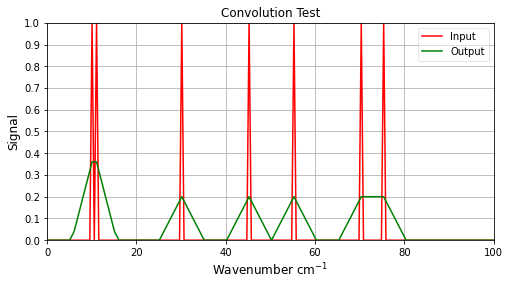

In [30]:
samplingresolution=0.5
wavenum=np.linspace(0, 100, int(100/samplingresolution))
inspectral=np.zeros(wavenum.shape)
inspectral[int(10/samplingresolution)] = 1
inspectral[int(11/samplingresolution)] = 1
inspectral[int(30/samplingresolution)] = 1
inspectral[int(45/samplingresolution)] = 1
inspectral[int(55/samplingresolution)] = 1
inspectral[int(70/samplingresolution)] = 1
inspectral[int(75/samplingresolution)] = 1
inwinwidth=1
outwinwidth=5
outspectral,  windowfn = ryutils.convolve(inspectral, samplingresolution,  inwinwidth,  outwinwidth)
convplot = ryplot.Plotter(1, 1, 1, figsize=(8,4))
convplot.plot(1, wavenum, inspectral, "Convolution Test", r'Wavenumber cm$^{-1}$',\
            r'Signal', ['r'],label=['Input'],legendAlpha=0.5,maxNX=5,xAxisFmt="%.0f",pltaxis=[0,100,0,1]);
convplot.plot(1, wavenum, outspectral, "Convolution Test", r'Wavenumber cm$^{-1}$',\
            r'Signal', ['g'],label=['Output'],legendAlpha=0.5,maxNX=5,xAxisFmt="%.0f",pltaxis=[0,100,0,1]);

### Savitzky-Golay filter

The Savitzky-Golay filter smooths signals by by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares.

A Python implementation of this filter is available in the scipy library.  A one-dimensional version of the filter is also included in `pyradi.ryutils.SavitzkyGolay`.  

The example below shows a considerable ringing on the spiky input signal. Clearly this filter is not appropriate for this particular input signal. Another example (atmospheric transmittance) is shown below which better demonstrates the Savitzky-Golay filter performance.

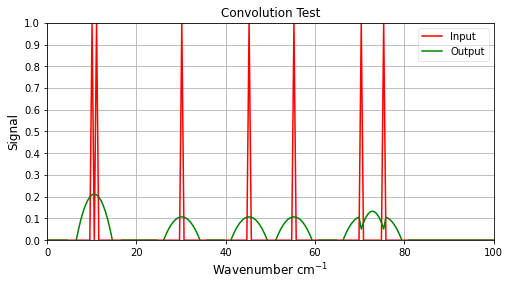

In [31]:
outspectral = ryutils.savitzkyGolay1D(inspectral, window_size=21, order=3, deriv=0, rate=1)

convplot = ryplot.Plotter(1, 1, 1, figsize=(8,4))
convplot.plot(1, wavenum, inspectral, "Convolution Test", r'Wavenumber cm$^{-1}$',\
            r'Signal', ['r'],label=['Input'],legendAlpha=0.5,maxNX=5,xAxisFmt="%.0f",pltaxis=[0,100,0,1]);
convplot.plot(1, wavenum, outspectral, "Convolution Test", r'Wavenumber cm$^{-1}$',\
            r'Signal', ['g'],label=['Output'],legendAlpha=0.5,maxNX=5,xAxisFmt="%.0f",pltaxis=[0,100,0,1]);

The next example uses spectral Bunsen flame measurement data. The data is read in from the pyradi Google Code site, so you must be online to run this cell.  The data is read using the urllib2 library, given the URL, the urllib2 returns a file handle that is used by Numpy to read the data.  The spectral width for the Bunsen flame measurement was 4 cm$^{-1}$ and the signal was sampled at 2 cm$^{-1}$. The Bunsen data file format is: first column contains the wavenumber and the second column contains the raw signal (proportional to radiance). Modtran transmittance data were calculated for a 5 m path length and a spectral width of 1 cm$^{-1}$ and sampling of 1 cm$^{-1}$. The transmittance file format is: first column contains the wavenumber and the second column contains the transmittance. The atmospheric transmittance is convolved to resolutions of 4 cm$^{-1}$ and 40 cm$^{-1}$.  The spectral baselines for the Bunsen data and Modtran data are not the same, so the Bunsen data is re-sampled at the Modtran spectral values. All the data is then plotted for visual inspection.  The convolution smoothing effect is clearly visible in the graphs.

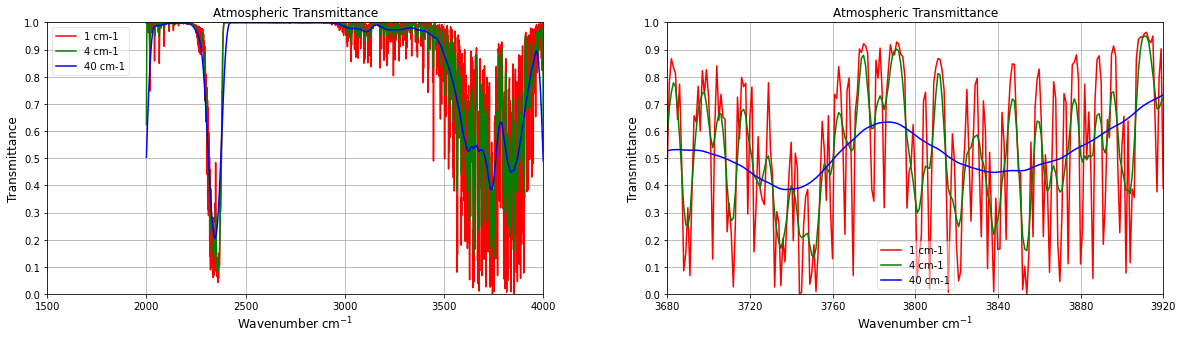

In [32]:
from scipy.interpolate import  interp1d
import pyradi.ryfiles as ryfiles

bunsenfile = ryfiles.downloadFileUrl(url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/bunsenspec.txt')
specRad = np.loadtxt(bunsenfile, comments='%', delimiter=' ')    

atmofile = ryfiles.downloadFileUrl(url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/atmotrans5m.txt')
tauAtmo = np.loadtxt(atmofile, comments='%', delimiter=' ' )   
wavenum =  tauAtmo[:, 0]
tauA = tauAtmo[:, 1]

# convolve transmittance from 1cm-1 to 4 cm-1
tauAtmo4,  windowfn = ryutils.convolve(tauA, 1, 1, 4)
# convolve transmittance from 1cm-1 to 40 cm-1
tauAtmo40,  windowfn = ryutils.convolve(tauA, 1, 1, 40)

#interpolate bunsen spectrum to atmo sampling
#first construct the interpolating function, using bunsen
bunInterp1 = interp1d(specRad[:,0], specRad[:,1])
#then call the function on atmo intervals
bunsen = bunInterp1(wavenum)

atmoplot = tauA.copy()
atmoplot =  np.vstack((atmoplot, tauAtmo4, tauAtmo40))
convplot02 = ryplot.Plotter(1, 1, 2,figsize=(20,5))
convplot02.plot(1, wavenum, atmoplot.T, "Atmospheric Transmittance", r'Wavenumber cm$^{-1}$',
            r'Transmittance', ['r', 'g','b'],label=['1 cm-1', '4 cm-1', '40 cm-1' ],legendAlpha=0.5,
                maxNX=5,xAxisFmt="%.0f",pltaxis=[1750,4000,0,1]);
convplot02.plot(2, wavenum, atmoplot.T, "Atmospheric Transmittance", r'Wavenumber cm$^{-1}$',
            r'Transmittance', ['r', 'g','b'],label=['1 cm-1', '4 cm-1', '40 cm-1' ],legendAlpha=0.5,
            pltaxis=[3700, 3900, 0, 1],maxNX=5,xAxisFmt="%.0f");


The next step is to attempt to correct for the atmospheric transmittance present during the measurement. In this particular case the simple approach of dividing the radiance signal by the transmittance is attempted. The case on the left side is for the Bunsen data at 4 cm$^{-1}$ resolution and the atmospheric transmittance (mismatched at) at 1 cm$^{-1}$. The case on the right side is for the Bunsen data at 4 cm$^{-1}$ resolution and the atmospheric transmittance (well matched at) at 4 cm$^{-1}$.  The results from the mismatched calculation is clearly much more noisy than the results for the well-matched calculation.  The results also show that it is impossible to reconstruct the signal in spectral regions where there is zero signal  - a more sophisticated model-based method must be followed, such as explained in (Sec 8.4).

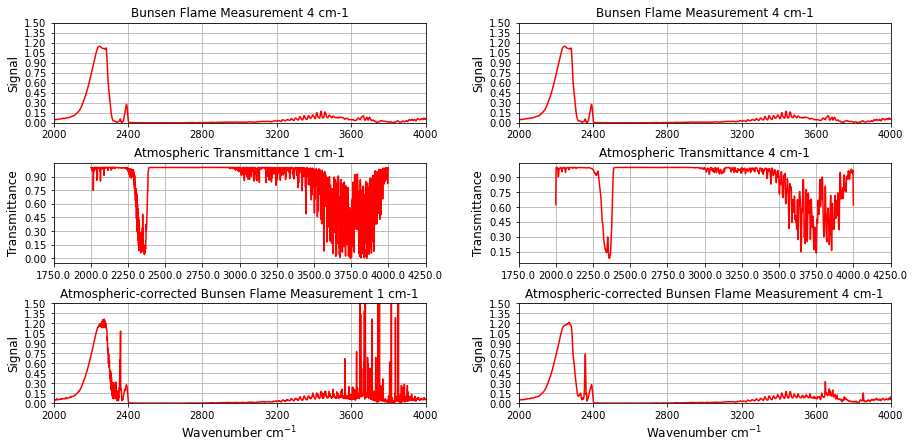

In [33]:
bunsenPlt = ryplot.Plotter(1,3, 2, figsize=(15,7))
bunsenPlt.plot(1, wavenum, bunsen, "Bunsen Flame Measurement 4 cm-1", r'',
            r'Signal', ['r'], pltaxis =[2000, 4000, 0,1.5],maxNX=5,xAxisFmt="%.0f");
bunsenPlt.plot(2, wavenum, bunsen, "Bunsen Flame Measurement 4 cm-1", r'',
            r'Signal', ['r'], pltaxis =[2000, 4000, 0,1.5],maxNX=5,xAxisFmt="%.0f");
bunsenPlt.plot(3, wavenum, tauA, "Atmospheric Transmittance 1 cm-1", r'',
            r'Transmittance', ['r'])
bunsenPlt.plot(4, wavenum, tauAtmo4, "Atmospheric Transmittance 4 cm-1", r'',
            r'Transmittance', ['r'])
bunsenPlt.plot(5, wavenum, bunsen/tauA, "Atmospheric-corrected Bunsen Flame Measurement 1 cm-1", r'Wavenumber cm$^{-1}$',
            r'Signal', ['r'], pltaxis =[2000, 4000, 0,1.5],maxNX=5,xAxisFmt="%.0f");
bunsenPlt.plot(6, wavenum, bunsen/tauAtmo4, "Atmospheric-corrected Bunsen Flame Measurement 4 cm-1", r'Wavenumber cm$^{-1}$',
            r'Signal', ['r'], pltaxis =[2000, 4000, 0,1.5],maxNX=5,xAxisFmt="%.0f");

The atmospheric transmittance model is next Savitzky-Golay filtered. This filter is poular in the spectroscopy community, so it should work well for the atmospheric transmittance data used here.  It indeed does provide nicely filtered spectra, as seen below.  More work is required to accurately translate the SG filter parameters to spectral widths.

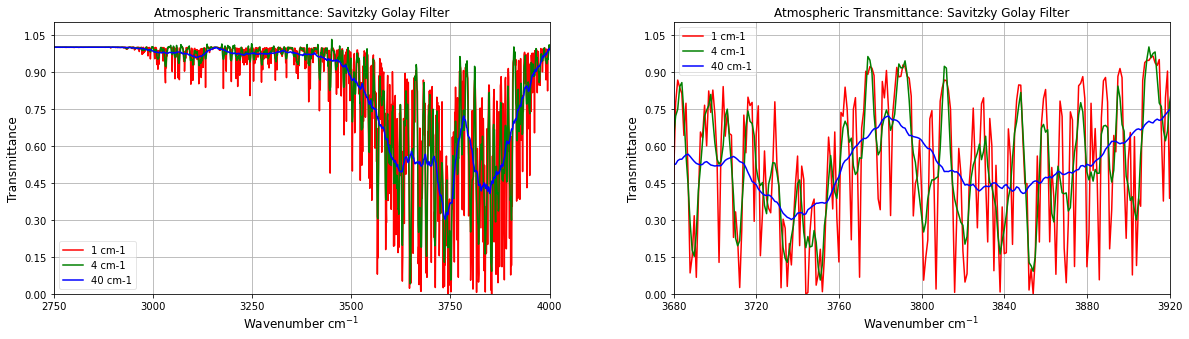

In [34]:
from scipy.interpolate import  interp1d
import pyradi.ryfiles as ryfiles

bunsenfile = ryfiles.downloadFileUrl(url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/bunsenspec.txt')
specRad = np.loadtxt(bunsenfile, comments='%', delimiter=' ')    

atmofile = ryfiles.downloadFileUrl(url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/atmotrans5m.txt')
tauAtmo = np.loadtxt(atmofile, comments='%', delimiter=' ' )   
wavenum =  tauAtmo[:, 0]
tauA = tauAtmo[:, 1]

# convolve transmittance from 1cm-1 to 4 cm-1
tauAtmo4 = ryutils.savitzkyGolay1D(tauA, window_size=9, order=3, deriv=0, rate=1)

# convolve transmittance from 1cm-1 to 40 cm-1
tauAtmo40 = ryutils.savitzkyGolay1D(tauA, window_size=81, order=3, deriv=0, rate=1)

#interpolate bunsen spectrum to atmo sampling
#first construct the interpolating function, using bunsen
bunInterp1 = interp1d(specRad[:,0], specRad[:,1])
#then call the function on atmo intervals
bunsen = bunInterp1(wavenum)

atmoplot = tauA.copy()
atmoplot =  np.vstack((atmoplot, tauAtmo4, tauAtmo40))
convplot02 = ryplot.Plotter(1, 1, 2,figsize=(20,5))
convplot02.plot(1, wavenum, atmoplot.T, "Atmospheric Transmittance: Savitzky Golay Filter", r'Wavenumber cm$^{-1}$',
            r'Transmittance', ['r', 'g','b'],label=['1 cm-1', '4 cm-1', '40 cm-1' ],legendAlpha=0.5,  
                pltaxis=[2900, 4000, 0, 1.1],maxNX=5,xAxisFmt="%.0f");
convplot02.plot(2, wavenum, atmoplot.T, "Atmospheric Transmittance: Savitzky Golay Filter", r'Wavenumber cm$^{-1}$',
            r'Transmittance', ['r', 'g','b'],label=['1 cm-1', '4 cm-1', '40 cm-1' ],legendAlpha=0.5,
            pltaxis=[3700, 3900, 0, 1.1],maxNX=5,xAxisFmt="%.0f");


## Colour calculations

This is a very high-level introduction to colour theory. For more detail see the numerous resources on the internet.  

(Sec 2.10.5) Colour is an elusive property - different people perceive colour differently, and the apparent colour of an object depends on the illuminance spectrum. The colour tristimulus have been standardised by the CIE.   It is interesting to note that the red colour stimilus has a significant component towards the blue part of the spectrum. The description in this section is very brief, for more details see (Sec 2.10).  The example given here investigates the  human perception of colour,  relative to the CIE 1931 standard.

This section explores the subtleties of colour as an application of 1) normalising, 2) radiometric concepts and 3) colour coordinates. Four sources are considered: the first light source is a 'daylight' fluorescent light source, the second source is the sun modelled as a thermal radiator at 5900~K, the third source is an incandescent light globe at a temperature of 2850~K, and the fourth source is a low-pressure sodium lamp. 

The samples illuminated by these sources are a red tomato, lettuce, a yellow prune, a dark-green leaf, a blue Nitrile (latex-like) surgical glove, and standard white printing paper.  The samples' diffuse reflection spectra were measured with a spectroradiometer, illuminating the sample with a bright light at short distance. The fruit samples all demonstrated considerable light propagation deeper into the fruit. The blue glove was located on a Spectralon white reference (note the considerable 'white' reflectance beyond 0.55 $\mu$m).


Use a local copy of the data file, if the tgz file is available in the same directory where the notebook is located. Otherwise download the 28 KB file from the internet.  Once availabe, unzip and untar the data files to support rest of the calculation.

In [35]:
import pyradi.ryfiles as ryfiles
import os
                
tgzFilename = 'colourcoordinates.tgz'
destinationDir = '.'
tarFilename = 'colourcoordinates.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/colourcoordinates/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)

print('filesAvailable is {}'.format(dlNames))

filesAvailable is ['ciexyz31_1.txt', 'fluorescent.txt', 'LowPressureSodiumLamp.txt', 'sampleReflectance.txt', 'samplesVis.txt']


The data is read with  `ryfiles.loadColumnTextFile`. 
This function loads column data from a text file, scaling and interpolating the read-in data, according to user specification.
The first 0'th column has special significance: it is considered the abscissa (x-values) of the data set, while the remaining columns are any number of ordinate (y-value) vectors.  The user passes a list of columns to be read (default is [1]) - only these columns are read, processed and returned when the function exits.
The user also passes an abscissa vector to which the input data is interpolated and then subsequently amplitude scaled or normalised.  

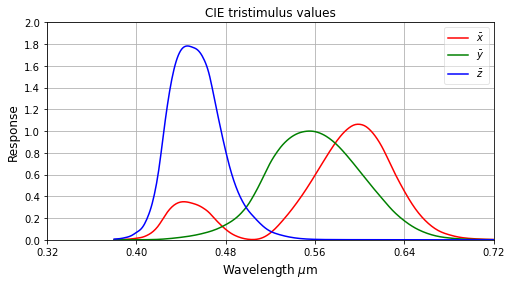

In [36]:
if dlNames:
    
    wavelength = np.linspace(0.38, 0.72, 350).reshape(-1, 1)
    
    bar = ryfiles.loadColumnTextFile('ciexyz31_1.txt', abscissaOut=wavelength,
                    loadCol=[1, 2, 3], comment='%', delimiter=',', abscissaScale=1e-3)
    
    cietriplt = ryplot.Plotter(1, 1, 1, figsize=(8,4))
    cietriplt.plot(1, wavelength, bar, "CIE tristimulus values",
            r'Wavelength $\mu$m', r'Response', plotCol = ['r','g','b'],
            label=['$\\bar{x}$', '$\\bar{y}$', '$\\bar{z}$'],pltaxis=[0.38,0.72,0,2],legendAlpha=0.5,maxNX=5,xAxisFmt="%.2f");

Next the source spectra are loaded and/or calculated. 
The following code builds a 2-D array with the source radiance values, 
where each column represents a different source. Wavelength extends along rows.
Spectral interval for all source spectra is the same, which is the `wavelength`
array calculated in the previous cell.
Blackbody radiance spectra are calculated at the required wavelength intervals 
for the required temperatures.
All data read from files are interpolated to the required wavelength intervals

The spectra from the four sources are stacked horizontally by using 
`numpy.hstack`. The resulting array varies with wavelength along the rows (axis=0),
with the four source spectra are given in the four columns.

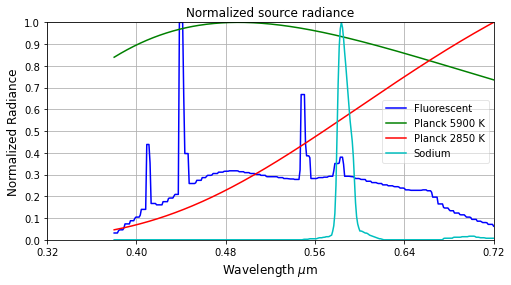

In [38]:
if dlNames:
    
    sources = ryfiles.loadColumnTextFile('fluorescent.txt',
        abscissaOut=wavelength,comment='%', normalize=1).reshape(-1,1)
    sources = np.hstack((sources, ryplanck.planck(wavelength,5900,'el').reshape(-1,1)))
    sources = np.hstack((sources, ryplanck.planck(wavelength,2850,'el').reshape(-1,1)))
    sources = np.hstack((sources, ryfiles.loadColumnTextFile('LowPressureSodiumLamp.txt', 
                                       abscissaOut=wavelength,comment='%', 
                                       normalize=1).reshape(-1,1) ))
    #label sources in order of appearance
    sourcesTxt=['Fluorescent', 'Planck 5900 K', 'Planck 2850 K', 'Sodium']
    
    #normalise the source data (along axis-0, which is along columns)
    #this is not really necessary for CIE xy calc, which normalises itself.
    #It is however useful for plotting the curves.
    sources /= np.max(sources,axis=0)
    
    srceplt = ryplot.Plotter(2, 1, 1, figsize=(8,4))
    srceplt.plot(1, wavelength, sources, "Normalized source radiance",
                r'Wavelength $\mu$m', r'Normalized Radiance',label=sourcesTxt,legendAlpha=0.5,pltaxis=[0.38,0.72,0,1],maxNX=5,xAxisFmt="%.2f");

Next load the sample reflectance data.  The data file for this data 
has the wavelength ($\mu$m) values along the first column, with many columns
following to represent the different samples.  Only a few of the samples (`samplesSelect = [1,2,3,8,10,11]`) are loaded here.

After reading in the numeric values, the headers in the first row is read in.
These headers are used in labels in the graphs.

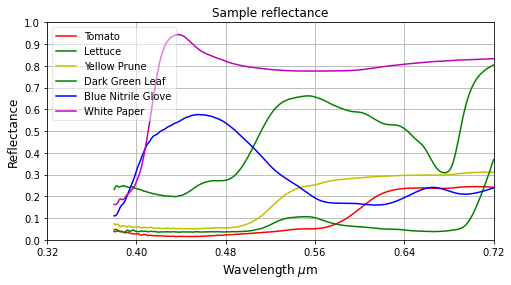

In [39]:
if dlNames:
    
    samplesSelect = [1,2,3,8,10,11]
    samples = ryfiles.loadColumnTextFile('samplesVis.txt', abscissaOut=wavelength, 
                                         loadCol=samplesSelect,  comment='%')
    samplesTxt=ryfiles.loadHeaderTextFile('samplesVis.txt',
                loadCol=samplesSelect, comment='%')
    smpleplt = ryplot.Plotter(1, 1, 1, figsize=(8,4))
    smpleplt.plot(1, wavelength, samples, "Sample reflectance", r'Wavelength $\mu$m',
                r'Reflectance', ['r', 'g', 'y','g', 'b', 'm'],label=samplesTxt,legendAlpha=0.5,pltaxis=[0.38,0.72,0,1],maxNX=5,xAxisFmt="%.2f");

Now calculate the CIE x,y coordinates for each combination of source and sample.  The x,y coordinates indicate the colour of the sample under the specific source illumination.  This cell uses the `rychroma.chromaticityforSpectralL` function to do the coordinate calculation from the spectra.  For equations and more details see (Sec 2.10).

We have a number of samples and a number of sources, essentially these two are orthogonal to each other.  The following calculation is therefore done in two loops and the results written to two-dimensional arrays for storage and subsequent plotting.  The two arrays are pre-allocated and filled with zeros before the calculation.

In [41]:
if dlNames:
    import pyradi.rychroma as rychroma
    
    xs = np.zeros((samples.shape[1],sources.shape[1]))
    ys = np.zeros((samples.shape[1],sources.shape[1]))
    for iSmpl in range(samples.shape[1]):
        for iSrc in range(sources.shape[1]):
            [ xs[iSmpl,iSrc], ys[iSmpl,iSrc], Y]=\
                rychroma.chromaticityforSpectralL(wavelength,
                (samples[:,iSmpl]*sources[:,iSrc]).reshape(-1, 1),
                bar[:,0], bar[:,1], bar[:,2])

This cell calculates the horseshoe-shape locus of monochromatic light.  The concept is really quite simple: create a monochromatic spectrum (only one wavelength) and then use  `rychroma.chromaticityforSpectralL` to calculate the x,y coordinates for that wavelength.

In [42]:
if dlNames:
    xm = np.zeros(wavelength.shape)
    ym = np.zeros(wavelength.shape)
    #create a series of data points with unity at specific wavelength
    for iWavel in range(wavelength.shape[0]):
        monospectrum = np.zeros(wavelength.shape)
        monospectrum[iWavel] = 1
        #calc xy for single mono wavelength point
        [xm[iWavel],ym[iWavel],Y] = rychroma.chromaticityforSpectralL(wavelength,
                monospectrum, bar[:,0], bar[:,1], bar[:,2])

Finally plot the colour coordinates for each sample-source combination on the diagram, together with the monochromatic horseshoe.  The graph is plotted trice; once to get the big picture and then two zoomed in on the detail.

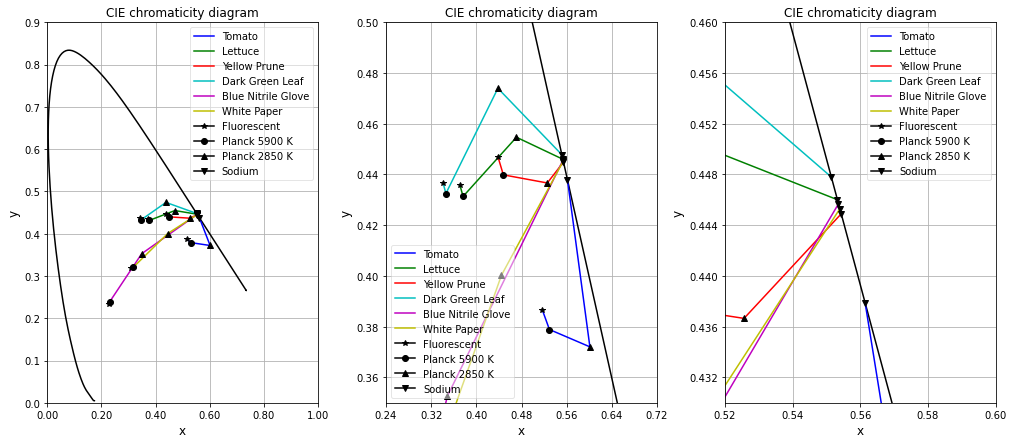

In [43]:
if dlNames:
    ciexyplt = ryplot.Plotter(4, 1, 3, figsize=(17,7))
    for i,pltaxis in enumerate([[0, 0.9, 0, 0.9],[0.3, 0.65, 0.35, 0.5],[0.52, 0.6, 0.43, 0.46]]):
        ciexyplt.resetPlotCol()
        #plot monochromatic horseshoe
        ciexyplt.plot(i+1, xm, ym, plotCol=['k'],pltaxis=pltaxis)
        #plot chromaticity loci for samples
        styleSample=['r--', 'g-.', 'y', 'g', 'b-', 'k']
        for iSmpl in range(samples.shape[1]):
            ciexyplt.plot(i+1,xs[iSmpl],ys[iSmpl], [styleSample[iSmpl]],
                    label=[samplesTxt[iSmpl]], legendAlpha=0.5,
                    pltaxis=pltaxis)
            
        #plot source markers
        styleSource=['*', 'o', '^', 'v']
        for iSmpl in range(samples.shape[1]):
            for iSrc in range(sources.shape[1]):
                if iSmpl==0:
                    legend=[sourcesTxt[iSrc]]
                else:
                    legend=''
                ciexyplt.plot(i+1,xs[iSmpl,iSrc],ys[iSmpl,iSrc],
                              "CIE chromaticity diagram", r'x',r'y',\
                        ['k'],label=legend,legendAlpha=0.5,
                        pltaxis=pltaxis, markers=[styleSource[iSrc]],maxNX=5,xAxisFmt="%.2f");


It is quite evident that for the two 'daylight' sources (the sun 5900 K and the fluorescent source) the sample colour coordinates are widely scattered over the coordinate space.  When the same samples are viewed under 2850 K source illumination (incandescent lamp) the colours tend to cluster towards the yellow - this matches the human experience that incandescent lamps produce yellow colour photographs.  Finally, when viewed under sodium illumination the sample colour coordinates converge on the colour of the lamp, meaning that the samples all appear yellow  in colour (589 nm) and only differ in shade.

The CIE 1931 chromaticity diagram in colour is shown below.

In [45]:
HTML('<img src="images/2000px-CIE-1931_diagram_in_LAB_space.svg.png" width=600 height=600/>')

## Solid Angles and Spatial Integrals

Computational radiometry has a strong element of geometry: sources and receivers have size, shape and orientation and are related to each over in some geometrical relationship. The calculation of solid angle is an essential task in most radiometric analyses.
The calculation of a solid angle requires integration across a spatial extent as described in (Sec 2.5.4).  Array processing in Python condenses and simplifies most two-dimensional calculations significantly. 

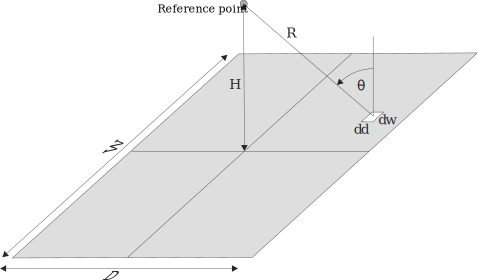

In [46]:
from IPython.display import SVG
SVG(filename='images/solidangleflatplate.svg')

The solid angle of a rectangular flat surface, with dimensions $W$ and $D$, as seen from a reference point centered above the surface, is determined by the integral of the projected area of a small elemental area $\cos\theta\,dd\,dw$ across the full size of the surface:
$$
\omega_{\rm s}=\int_W\int_D\frac{dw\,dd\,\cos^{n-2}\theta}{R^2}
$$
$$
\omega_{\rm s}=\int_W\int_D\frac{dw\,dd\,\cos^n\theta}{H^2}
$$
$$
\omega_{\rm s}=\int_W\int_D\frac{dw\,dd\,}{H^2}\left(\frac{H}{R}\right)^n
$$
$$\omega_{\rm s}=\int_W\int_D\frac{dw\,dd\,}{H^2}\left(\frac{H}{\sqrt{w^2+d^2+H^2}}\right)^n, 
$$
where $H$ is the reference point height above the surface, and $n=3$ for the geometrical solid angle and $n=4$ for the projected solid angle. The integral is performed along the $W$ and $D$ dimensions with increments of $dw$ and $dd$. The slant range between the reference point and the elemental area $dd\times dw$ is $R=H/\cos\theta$.

This example calculates the geometric and projected solid angles of a 5 m $\times$ 5 m floor from a sensor centered above the floor at a height of 3.5 m.  The solid angles thus calculated are compared to the (incorrect) $W\times D/R^2$ approximation of (5 m $\times$ 5 m)/(3.5 m $\times$ 3.5 m).  We investigate the accuracy of the answer for a variable number of samples.  It seems you need at least `500**2` samples.

In [47]:
import numpy as np
h = 3.5
d = 5.
w = 5.

wdh2 = w * d / (h * h)
print('Approximated solid aAngle is {} sr\n'.format(wdh2))
for samples in [1001, 501, 101, 51, 21]:
    varx = np.linspace(-d/2, d/2, samples)
    vary = np.linspace(-w/2, w/2, samples)
    x, y = np.meshgrid(varx, vary)
    for n,stext in zip([3., 4.], ['Geometric','Projected'] ):
        gv = (1. / ( (x / h) ** 2 + (y / h) ** 2 + 1 ) ) ** (n / 2)
        solidAngle = np.trapz(np.ravel(gv), dx=w*d/(samples**2))/(h*h)
        error = 100 * (solidAngle - wdh2) / solidAngle
        print('{0} solid aAngle is {1} sr [error is {2:.2f}%] with {3}x{3} samples'.\
              format(stext, solidAngle,error, samples))
    print(' ')

Approximated solid aAngle is 2.0408163265306123 sr

Geometric solid aAngle is 1.3776190916848792 sr [error is -48.14%] with 1001x1001 samples
Projected solid aAngle is 1.2231417346316624 sr [error is -66.85%] with 1001x1001 samples
 
Geometric solid aAngle is 1.3767628046966296 sr [error is -48.23%] with 501x501 samples
Projected solid aAngle is 1.2221732303536663 sr [error is -66.98%] with 501x501 samples
 
Geometric solid aAngle is 1.3698950234892486 sr [error is -48.98%] with 101x101 samples
Projected solid aAngle is 1.2144328695069617 sr [error is -68.05%] with 101x101 samples
 
Geometric solid aAngle is 1.361269842026548 sr [error is -49.92%] with 51x51 samples
Projected solid aAngle is 1.2047779728077308 sr [error is -69.39%] with 51x51 samples
 
Geometric solid aAngle is 1.335175107784089 sr [error is -52.85%] with 21x21 samples
Projected solid aAngle is 1.1759711205782946 sr [error is -73.54%] with 21x21 samples
 


Experiment a little with the meshgrid and its results. What do these variables look like graphically? Calculate and plot, for each tile: (1) the distance from the reference point, (2) the solid angle of the angle to the reference point, (3) the geometric solid angle of each tile, and (4) the projected solid angle of each tile.  Along the way plot the values of x and y as well.

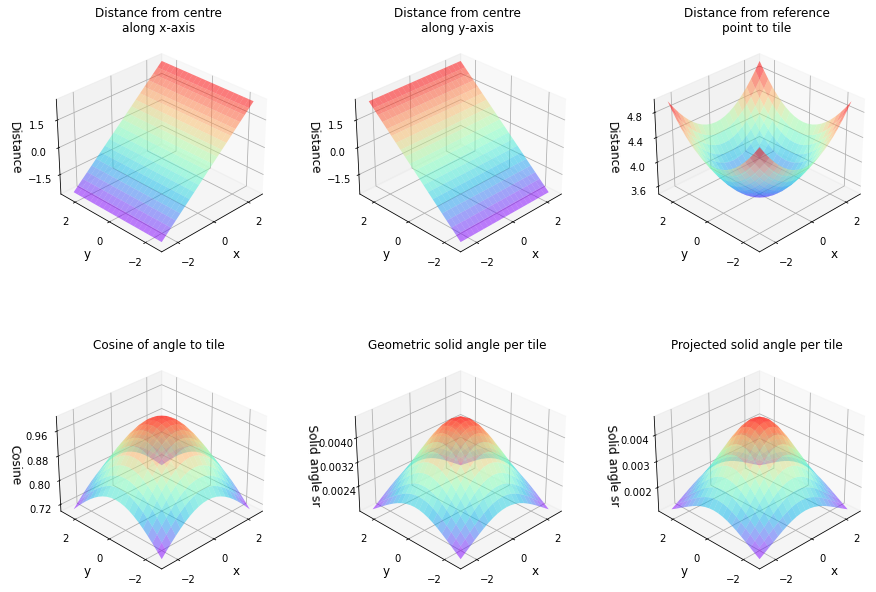

In [48]:
distFromRef = np.sqrt(x ** 2 + y ** 2 + h * h)
cosAngle = h / distFromRef
geoSolid = w * d / (samples ** 2) * cosAngle / distFromRef ** 2
prjsolid = geoSolid * cosAngle

p = ryplot.Plotter(1,2, 3, figsize=(15,10))
p.mesh3D(1, x, y, x, ptitle='Distance from centre\nalong x-axis', 
         xlabel='x', ylabel='y', zlabel='Distance', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);
p.mesh3D(2, x, y, y, ptitle='Distance from centre\nalong y-axis', 
         xlabel='x', ylabel='y', zlabel='Distance', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);
p.mesh3D(3, x, y, distFromRef, ptitle='Distance from reference\npoint to tile', 
         xlabel='x', ylabel='y', zlabel='Distance', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);
p.mesh3D(4, x, y, cosAngle, ptitle='Cosine of angle to tile', 
         xlabel='x', ylabel='y', zlabel='Cosine', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);
p.mesh3D(5, x, y, geoSolid, ptitle='Geometric solid angle per tile', 
         xlabel='x', ylabel='y', zlabel='Solid angle sr', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);
p.mesh3D(6, x, y, prjsolid, ptitle='Projected solid angle per tile', 
         xlabel='x', ylabel='y', zlabel='Solid angle sr', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);


Compare the projected and geometric solid angles. Note that directly under the reference point the geometric and projected solid angles are equal (because $\cos(0)=1$), but at the corners the cosine weighting function starts to weigh the projected solid angle down.

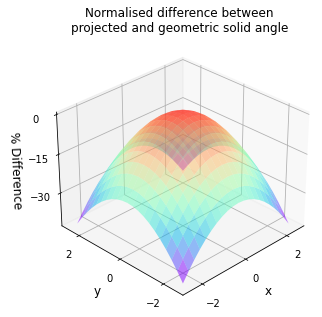

In [49]:
p = ryplot.Plotter(1,1,1,figsize=(5,5))
p.mesh3D(1, x, y, 100 * (prjsolid - geoSolid) / prjsolid , 
         ptitle='Normalised difference between\nprojected and geometric solid angle', 
         xlabel='x', ylabel='y', zlabel='% Difference', 
         maxNX=3, maxNY=3, maxNZ=4, alpha=0.5, xInvert=True, yInvert=True);


Another approach, provided by a student, is to do the integral as two separate summations. The first summation is in `sigmaGSD = sigmaGSD + ....` and the second summation is in `GeoSA = sum(sigmaGSD)`.  This approach is perhaps more intuitive to some, but requires a `for` loop [which is perfectly legal, but superfluous in my personal programming mindset].

In [50]:
#Credit to Wynand Lambrechts
sampleSize = 1000
D_ = 5.
H_ = 3.5
smallDimension = D_/sampleSize
all_d = np.linspace(-D_/2,D_/2,sampleSize)
all_w = np.linspace(-D_/2,D_/2,sampleSize)
sigmaGSD = 0.
sigmaPSD = 0.

#THIS EQUATION DETERMINES THE GEOMETRICAL SUMMATION OF EQUATION 2.13 ON PAGE 32
for x in all_w:
    sigmaGSD = sigmaGSD + (H_/np.sqrt(np.power((x**2 + all_d**2 + H_**2),(3))))*smallDimension**2
    
#THIS EQUATION DETERMINES THE PROJECTED SUMMATION OF EQUATION 2.14 ON PAGE 33
for y in all_w:
    sigmaPSD = sigmaPSD + (H_*H_/np.sqrt(np.power((y**2 + all_d**2 + H_**2),(4))))*smallDimension**2

GeoSA = sum(sigmaGSD)    
ProSA = sum(sigmaPSD)    
print(GeoSA)
print(ProSA)


1.3776189454252532
1.2231412650040754


# Python and module versions, and dates


In [51]:
try:
    import pyradi.ryutils as ryutils
    print(ryutils.VersionInformation('matplotlib,numpy,pyradi,scipy,pandas'))
except:
    print("pyradi.ryutils not found")

Software versions
Python:   3.8.3 64bit [MSC v.1916 64 bit (AMD64)]
IPython:   7.22.0
OS:   Windows 10 10.0.19041 SP0
matplotlib:   3.3.4
numpy:   1.19.2
pyradi:   1.1.4
scipy:   1.6.2
pandas:   1.2.4
Mon Sep 06 20:00:49 2021 South Africa Standard Time
